In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot
vapeplot.set_palette('vaporwave')

In [2]:
data = 'citeseer'

policies = [
    'greedy',
    'round robin greedy'
]

n_exps = 20
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones((len(policies), n_exps, budget)) * -1

for p_ind, policy in enumerate(policies):
    for i in range(n_exps):
        tmp_utilities = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__utilities__{i + 1}.csv'), 
            dtype=float
        ).flatten()
        
        utilities[p_ind, i, :] = tmp_utilities
        
assert np.all(utilities != -1)

In [6]:
utilities[..., -1].mean(axis=1)

array([17.03505848, 16.75134239])

greedy: 17.0351
round robin greedy: 16.7513


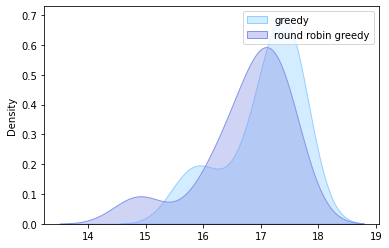

In [7]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

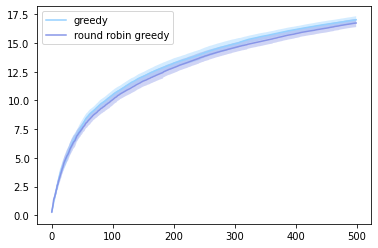

In [3]:
for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(budget), lower, upper, alpha=0.4)
    
plt.legend();